Import modules


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
from pprint import pprint
import utils as u

Loading training and testing data

In [2]:
plt.ion()

# Load the LB and HB LSFs and convert them from Q15 format to their real value representation within (0, PI/2)
X = u.q15_to_lsf(np.load('./data/train/line_spectrum_frequency_low_band_speech.npy'))
y = u.q15_to_lsf(np.load('./data/train/line_spectrum_frequency_high_band_speech.npy'))

X_test = u.q15_to_lsf(np.load('./data/test/line_spectrum_frequency_low_band_speech.npy'))
y_test = u.q15_to_lsf(np.load('./data/test/line_spectrum_frequency_high_band_speech.npy'))

# appending delta features|
X = np.hstack((X, u.deltas(X)))
X_test = np.hstack((X_test, u.deltas(X_test)))


# We will let the model training handle data shuffle
X_train, X_valid, y_train, y_valid = u.train_valid_split(X, y, valid_size=0.1, shuffle=False, random_state=0)

# Calculate data size for training, validation and testing
num_train_data = X_train.shape[0]
num_valid_data = X_valid.shape[0]
num_test_data = X_test.shape[0]

# truncate training data size to 1%, 10%, 100% for training evaluation
samples_1 = num_train_data // 100
samples_10 = num_train_data // 10
samples_100 = num_train_data
results = {}

dim_x = X_train.shape[1]
dim_y = y_train.shape[1]

print("Input Dimension: %d" % (dim_x))
print("Output Dimension: %d" % (dim_y))

print("Total Training data %d, \tequivalent to %s in time" % (num_train_data, u.frame_to_hms(num_train_data)))
print("Total Validating data %d, \tequivalent to %s in time" % (num_valid_data, u.frame_to_hms(num_valid_data)))
print("Total Testing data %d, \tequivalent to %s in time" % (num_test_data, u.frame_to_hms(num_test_data)))

Input Dimension: 20
Output Dimension: 6
Total Training data 400953, 	equivalent to 2:13:39.060 in time
Total Validating data 44550, 	equivalent to 0:14:51.000 in time
Total Testing data 1386, 	equivalent to 0:00:27.720 in time


(0, 1.5707963267948966)

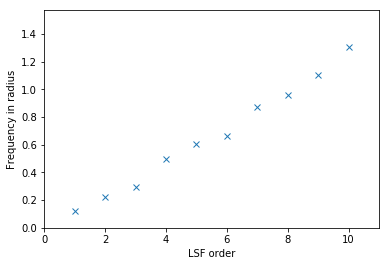

In [3]:
# visualized one set of 10th order LB LSF values
plt.plot(np.arange(1,11,1), X_train[0, :10], 'x')
plt.xlabel('LSF order')
plt.ylabel('Frequency in radius')
plt.xlim((0,11))
plt.ylim((0, np.pi/2))

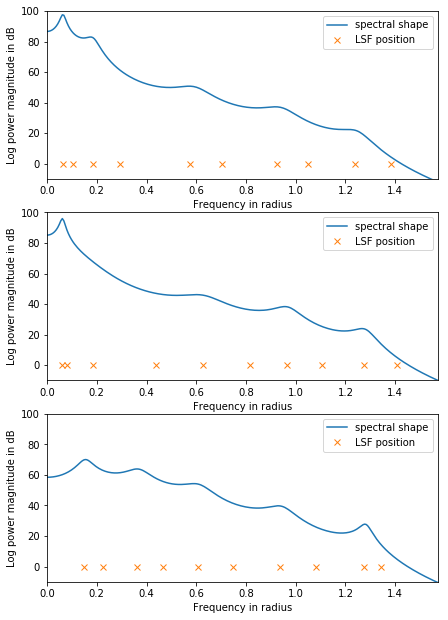

In [4]:
# Plot several 10th-order LB LSFs from training set together with their spectral representation
u.plot_lsf(X_train[10:13, :10])

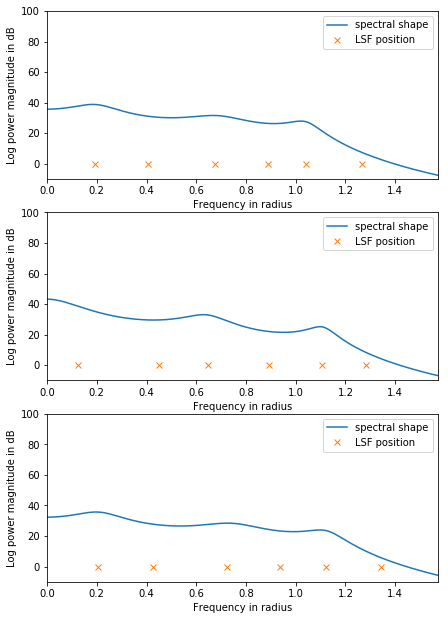

In [5]:
# Plot several 6th-order HB LSFs from training set together with their spectral representation
u.plot_lsf(y_train[10:13, :])

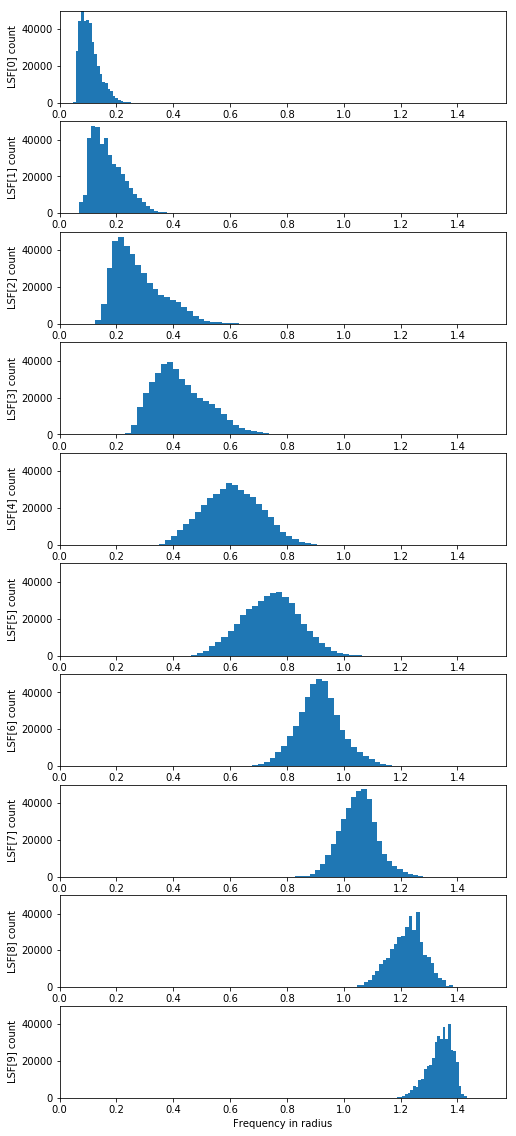

In [6]:
# Plot the histogram for each of the LB LSF dimension
u.plot_lsf_hist(X_train[:, :10])

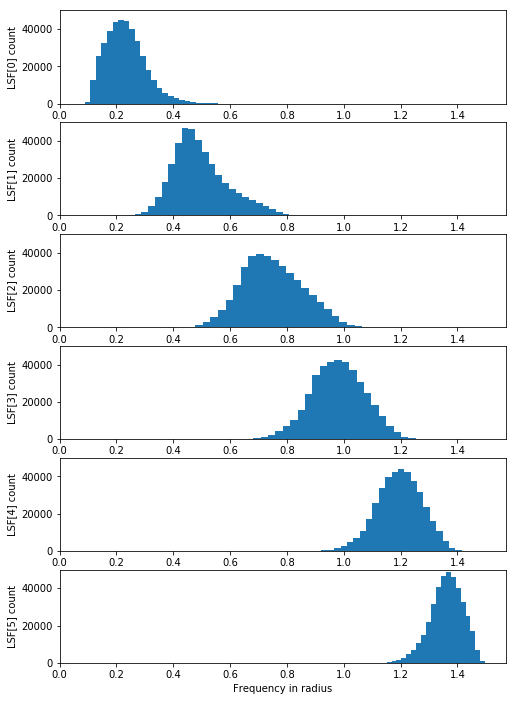

In [7]:
# Plot the histogram for each of the HB LSF dimension
u.plot_lsf_hist(y_train)

In [8]:
# Build benchmark VQ codebook model
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from scipy.cluster.vq import vq

def vq_evaluate(X, y, codebook):
    dim_x = X.shape[1]
    dim_y = y.shape[1]
    
    num_data = X.shape[0]
    c_id, _ = vq(X, codebook[:, :dim_x])
    
    yp = np.zeros_like(y)
    for i in range(num_data):
        yp[i, :] = codebook[c_id[i], -dim_y:]

    return mean_squared_error(y, yp)

model = MiniBatchKMeans(n_clusters=64, random_state=0)

results['VQ_Codebook'] = {}
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    
    # combine LB and HB LSFs for KMeans clustering
    start = time()
    model.fit(np.hstack((X_train[:samples, :], y_train[:samples, :])))
    end = time()
    
    codebook = np.array(model.cluster_centers_)
    error_train = vq_evaluate(X_train[:10000, :], y_train[:10000, :], codebook)
    error_valid = vq_evaluate(X_valid, y_valid, codebook)
    error_test = vq_evaluate(X_test, y_test, codebook)

    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("VQ Codebook trained on %d samples, taking %.2f seconds" % (samples, end-start))

    results['VQ_Codebook'][i] = result
    
pprint(results['VQ_Codebook'])

VQ Codebook trained on 4009 samples, taking 0.21 seconds
VQ Codebook trained on 40095 samples, taking 0.88 seconds
VQ Codebook trained on 400953 samples, taking 5.87 seconds
{0: {'error_test': 0.010442263825198217,
     'error_train': 0.00818465838212472,
     'error_valid': 0.010993911916785434},
 1: {'error_test': 0.010120221067082514,
     'error_train': 0.008074356462295654,
     'error_valid': 0.01013764485444497},
 2: {'error_test': 0.009632988358065997,
     'error_train': 0.009074556374404996,
     'error_valid': 0.009697422726592728}}


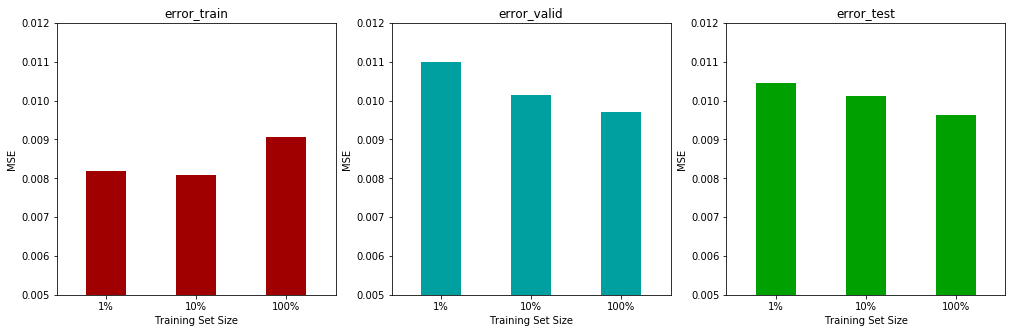

In [9]:
u.plot_model_result(results['VQ_Codebook'], ylim=(0.005, 0.012))

/usr2/senl/Project_Space/Anaconda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 126       
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________
Linear regression model trained on 4009 samples, taking 101.84 seconds
Linear regression model trained on 40095 samples, taking 53.92 seconds
Linear regression model trained on 400953 samples, taking 126.36 seconds
{0: {'error_test': 0.00963048699539031,
     'error_train': 0.007493329831212759,
     'error_valid': 0.009085579324559665},
 1: {'error_test': 0.008648559131255054,
     'error_train': 0.006781226419657469,
     'error_valid': 0.0081735269836956},
 2: {'error_test': 0.008181683907304147,
     'error_train': 0.006904922702908516,
     'error_valid': 0.008017902420133385}}


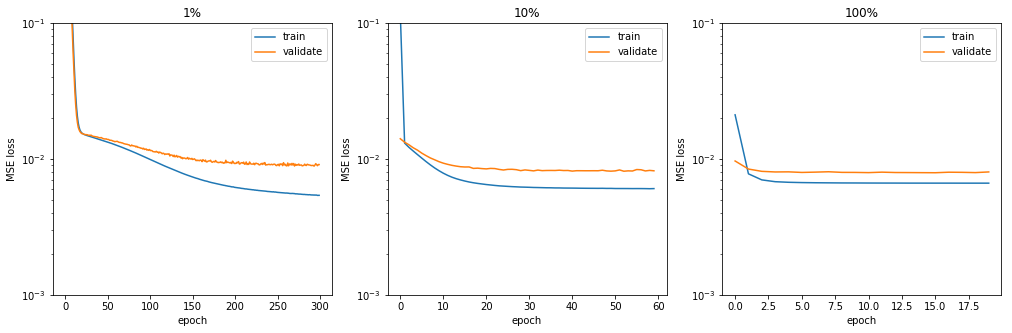

In [10]:
# Build benchmark linear regression model
from models import linear_regression

model = linear_regression(dim_x, dim_y)
params = model.get_weights()

results['Linear_Regression'] = {}
plt.figure(figsize=(17,5))
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    verbose = 0
    
    if samples == samples_1:
        n_epoch = 300
    elif samples == samples_10:
        n_epoch = 60
    else:
        n_epoch = 20
    
    start = time()
    model.set_weights(params)
    history = model.fit(X_train[:samples, :], y_train[:samples, :], epochs=n_epoch, batch_size=128, verbose=verbose, validation_data=(X_valid, y_valid), shuffle=True)
    end = time()
    
    error_train = model.evaluate(X_train[:10000, :], y_train[:10000, :], batch_size=128, verbose=verbose)
    error_valid = model.evaluate(X_valid, y_valid, batch_size=128, verbose=verbose)
    error_test = model.evaluate(X_test, y_test, batch_size=128, verbose=verbose)
    
    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("Linear regression model trained on %d samples, taking %.2f seconds" % (samples, end-start))
    
    titles = ["1%", "10%", "100%"]
    plt.subplot(1, 3, i+1)
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('MSE loss')
    plt.ylim((1e-3, 1e-1))
    plt.title(titles[i])
    plt.legend(['train', 'validate'], loc='upper right')
    
    results['Linear_Regression'][i] = result
    
pprint(results['Linear_Regression'])

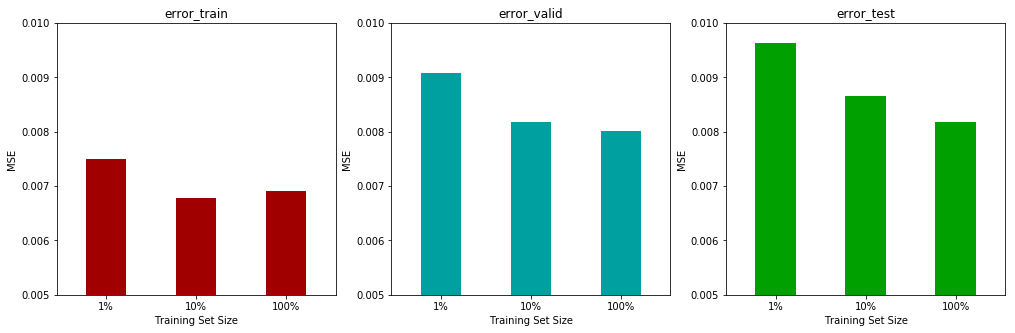

In [11]:
u.plot_model_result(results['Linear_Regression'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               2688      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 3,462
Trainable params: 3,462
Non-trainable params: 0
_________________________________________________________________
MLP model trained on 4009 samples, taking 40.40 seconds
MLP model trained on 40095 samples, taking 48.33 seconds
MLP model trained on 400953 samples, taking 194.52 seconds
{0: {'error_test': 0.008886860261575829,
     'error_train': 0.007168555088341236,
     'error_valid': 0.008720808462997613},
 1: {'error_test': 0.007873614618358503,
     'error_train': 0.006166403912007809,
     'error_valid': 0.007676961683280407},
 2: {'error_test': 0.0071558094533727456,
     'error_train': 0.006663600660860539,
     'error_valid': 0.007213

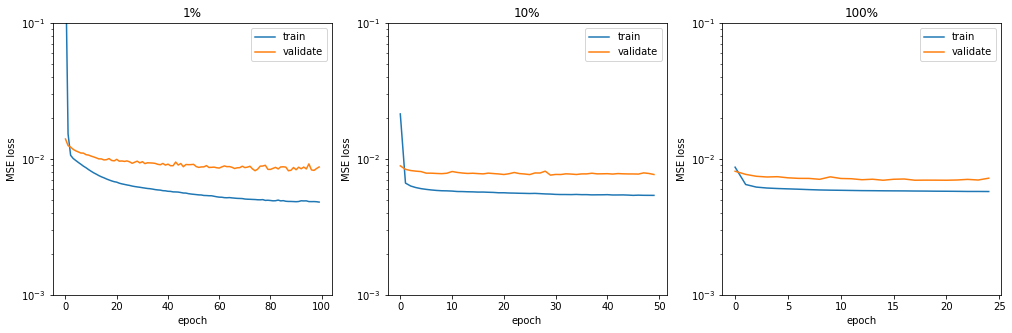

In [12]:
# Build 1 hidden layer MLP model
from models import mlp

model = mlp(dim_x, dim_y, nl=1, nn=128, dropout=False)
params = model.get_weights()

results['MLP'] = {}
plt.figure(figsize=(17,5))
for i, samples in enumerate([samples_1, samples_10, samples_100]):

    result = {}
    verbose = 0
    
    if samples == samples_1:
        n_epoch = 100
    elif samples == samples_10:
        n_epoch = 50
    else:
        n_epoch = 25
    
    start = time()
    model.set_weights(params)
    history = model.fit(X_train[:samples, :], y_train[:samples, :], epochs=n_epoch, batch_size=128, verbose=verbose, validation_data=(X_valid, y_valid), shuffle=True)
    end = time()
    
    error_train = model.evaluate(X_train[:10000, :], y_train[:10000, :], batch_size=128, verbose=verbose)
    error_valid = model.evaluate(X_valid, y_valid, batch_size=128, verbose=verbose)
    error_test = model.evaluate(X_test, y_test, batch_size=128, verbose=verbose)
    
    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("MLP model trained on %d samples, taking %.2f seconds" % (samples, end-start))
    
    titles = ["1%", "10%", "100%"]
    plt.subplot(1, 3, i+1)
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('MSE loss')
    plt.ylim((1e-3, 1e-1))
    plt.title(titles[i])
    plt.legend(['train', 'validate'], loc='upper right')
    
    results['MLP'][i] = result
    
pprint(results['MLP'])

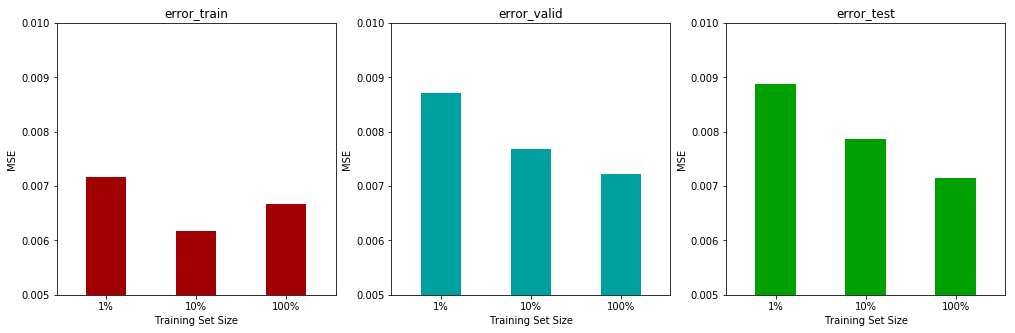

In [13]:
u.plot_model_result(results['MLP'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               2688      
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 774       
Total params: 36,486
Trainable params: 36,486
Non-trainable params: 0
_________________________________________________________________
MLP mo

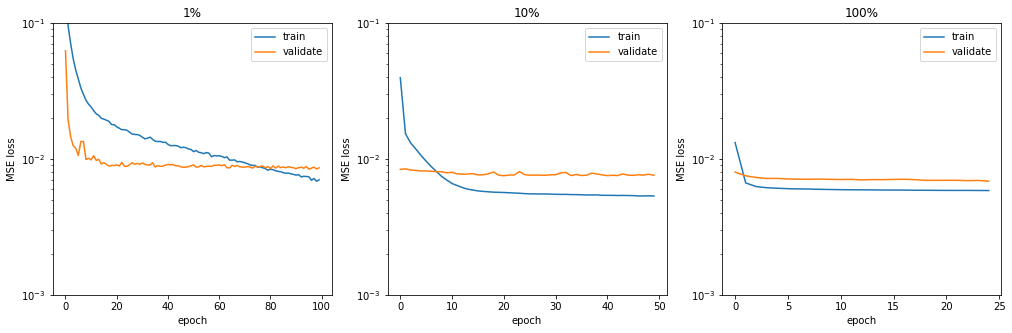

In [25]:
# Improve on the basic MLP model
from models import mlp

model = mlp(dim_x, dim_y, nl=3, nn=128, dropout=True)
params = model.get_weights()

results['MLP2'] = {}
plt.figure(figsize=(17,5))
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    verbose = 0
    
    if samples == samples_1:
        n_epoch = 100
    elif samples == samples_10:
        n_epoch = 50
    else:
        n_epoch = 25
    
    start = time()
    model.set_weights(params)
    history = model.fit(X_train[:samples, :], y_train[:samples, :], epochs=n_epoch, batch_size=128, verbose=verbose, validation_data=(X_valid, y_valid), shuffle=True)
    end = time()
    
    error_train = model.evaluate(X_train[:10000, :], y_train[:10000, :], batch_size=128, verbose=verbose)
    error_valid = model.evaluate(X_valid, y_valid, batch_size=128, verbose=verbose)
    error_test = model.evaluate(X_test, y_test, batch_size=128, verbose=verbose)
    
    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("MLP model trained on %d samples, taking %.2f seconds" % (samples, end-start))

    titles = ["1%", "10%", "100%"]
    plt.subplot(1, 3, i+1)
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('MSE loss')
    plt.ylim((1e-3, 1e-1))
    plt.title(titles[i])
    plt.legend(['train', 'validate'], loc='upper right')
    
    results['MLP2'][i] = result
    
pprint(results['MLP2'])

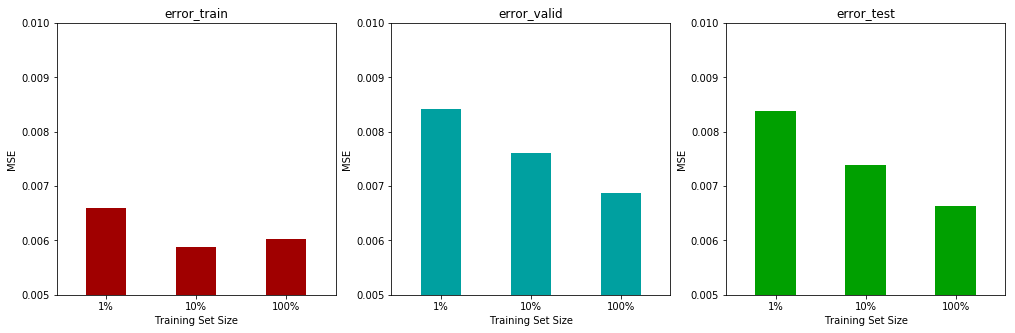

In [24]:
u.plot_model_result(results['MLP2'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               76288     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
Total params: 77,062
Trainable params: 77,062
Non-trainable params: 0
_________________________________________________________________
LSTM model trained on 4009 samples, taking 143.89 seconds
LSTM model trained on 40095 samples, taking 203.63 seconds
LSTM model trained on 400953 samples, taking 553.82 seconds
{0: {'error_test': 0.009381662022112767,
     'error_train': 0.007296925382316113,
     'error_valid': 0.009296345379617479},
 1: {'error_test': 0.00771808892509982,
     'error_train': 0.005524076780676842,
     'error_valid': 0.007731694493664368},
 2: {'error_test': 0.006519419742508927,
     'error_train': 0.00565941142141819,
     'error_valid': 0.00

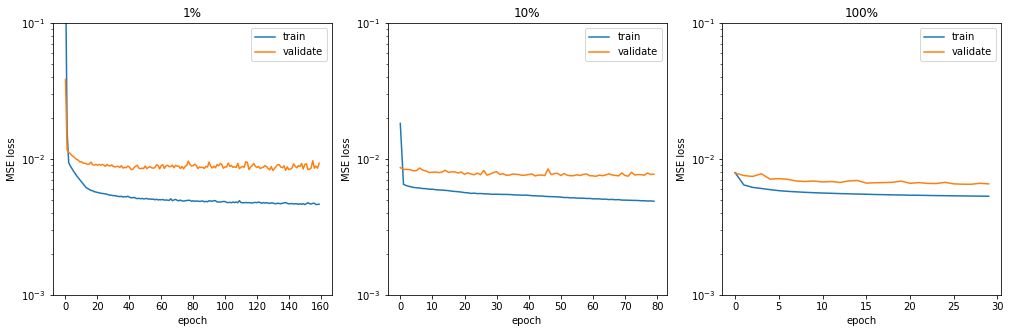

In [16]:
# Build basic LSTM model
from models import lstm

time_step = 2

X_train_rnn = u.transform_for_rnn(X_train, time_step=time_step)
X_valid_rnn = u.transform_for_rnn(X_valid, time_step=time_step)
X_test_rnn = u.transform_for_rnn(X_test, time_step=time_step)

model = lstm(dim_x, dim_y, time_step, nl=1, nn=128)
params = model.get_weights()

results['LSTM'] = {}
plt.figure(figsize=(17,5))
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    verbose = 0
    
    if samples == samples_1:
        n_epoch = 160
    elif samples == samples_10:
        n_epoch = 80
    else:
        n_epoch = 30
    
    start = time()
    model.set_weights(params)
    history = model.fit(X_train_rnn[:samples, :, :], y_train[:samples, :], epochs=n_epoch, batch_size=128, verbose=verbose, validation_data=(X_valid_rnn, y_valid), shuffle=True)
    end = time()
    
    error_train = model.evaluate(X_train_rnn[:10000, :, :], y_train[:10000, :], batch_size=128, verbose=verbose)
    error_valid = model.evaluate(X_valid_rnn, y_valid, batch_size=128, verbose=verbose)
    error_test = model.evaluate(X_test_rnn, y_test, batch_size=128, verbose=verbose)
    
    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("LSTM model trained on %d samples, taking %.2f seconds" % (samples, end-start))

    titles = ["1%", "10%", "100%"]
    plt.subplot(1, 3, i+1)
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('MSE loss')
    plt.ylim((1e-3, 1e-1))
    plt.title(titles[i])
    plt.legend(['train', 'validate'], loc='upper right')
    
    results['LSTM'][i] = result
    
pprint(results['LSTM'])

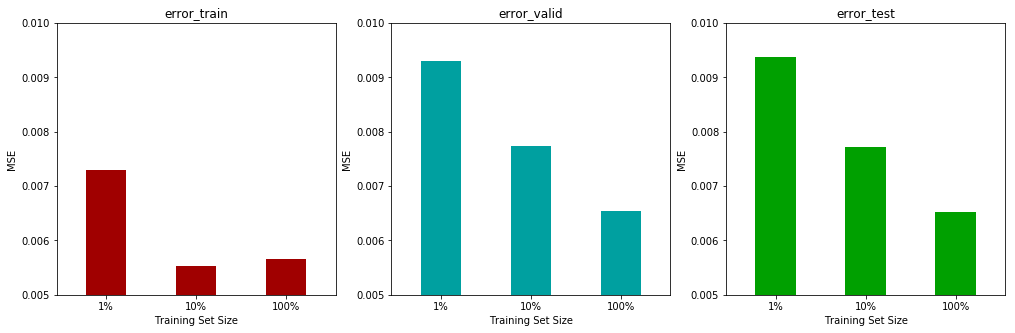

In [17]:
u.plot_model_result(results['LSTM'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               76288     
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 774       
Total params: 77,062
Trainable params: 77,062
Non-trainable params: 0
_________________________________________________________________
LSTM model trained on 4009 samples, taking 155.76 seconds
LSTM model trained on 40095 samples, taking 231.68 seconds
LSTM model trained on 400953 samples, taking 621.91 seconds
{0: {'error_test': 0.009273788492594446,
     'error_train': 0.00722740717753768,
     'error_valid': 0.009195647632366613},
 1: {'error_test': 0.007623118478777949,
     'error_train': 0.005268177474290132,
     'error_valid': 0.007835380080439292},
 2: {'error_test': 0.006592733987766986,
     'error_train': 0.0053763910070061685,
     'error_valid': 0.

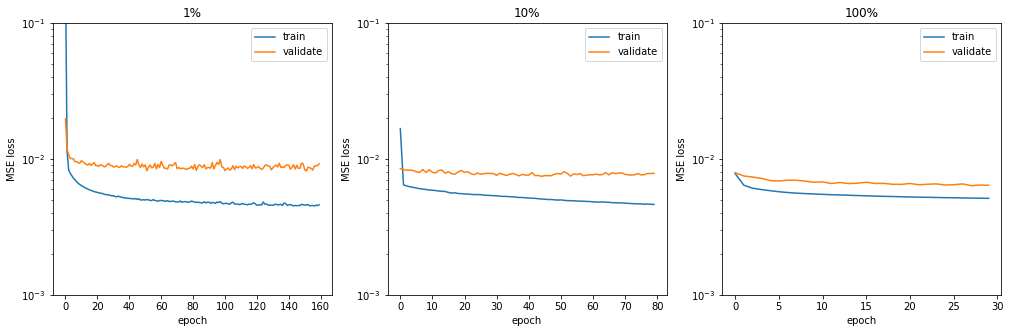

In [21]:
# Improve on basic LSTM model
from models import lstm

time_step = 3

X_train_rnn = u.transform_for_rnn(X_train, time_step=time_step)
X_valid_rnn = u.transform_for_rnn(X_valid, time_step=time_step)
X_test_rnn = u.transform_for_rnn(X_test, time_step=time_step)

# rolling to include future frames
X_train_rnn = np.roll(X_train_rnn, -1, axis=0)
X_valid_rnn = np.roll(X_valid_rnn, -1, axis=0)
X_test_rnn = np.roll(X_test_rnn, -1, axis=0)

model = lstm(dim_x, dim_y, time_step, nl=1, nn=128)
params = model.get_weights()

results['LSTM2'] = {}
plt.figure(figsize=(17,5))
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    verbose = 0
    
    if samples == samples_1:
        n_epoch = 160
    elif samples == samples_10:
        n_epoch = 80
    else:
        n_epoch = 30
    
    start = time()
    model.set_weights(params)
    history = model.fit(X_train_rnn[:samples, :, :], y_train[:samples, :], epochs=n_epoch, batch_size=128, verbose=verbose, validation_data=(X_valid_rnn, y_valid), shuffle=True)
    end = time()
    
    error_train = model.evaluate(X_train_rnn[:10000, :, :], y_train[:10000, :], batch_size=128, verbose=verbose)
    error_valid = model.evaluate(X_valid_rnn, y_valid, batch_size=128, verbose=verbose)
    error_test = model.evaluate(X_test_rnn, y_test, batch_size=128, verbose=verbose)
    
    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("LSTM model trained on %d samples, taking %.2f seconds" % (samples, end-start))

    titles = ["1%", "10%", "100%"]
    plt.subplot(1, 3, i+1)
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('MSE loss')
    plt.ylim((1e-3, 1e-1))
    plt.title(titles[i])
    plt.legend(['train', 'validate'], loc='upper right')
    
    results['LSTM2'][i] = result
    
pprint(results['LSTM2'])

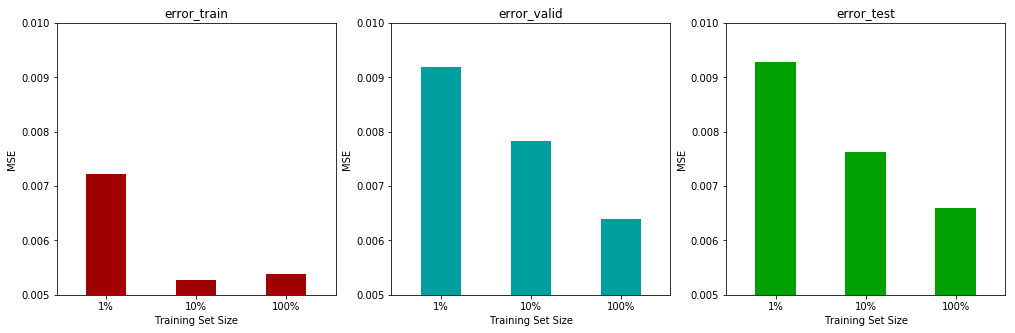

In [22]:
u.plot_model_result(results['LSTM2'])